># **Ciência dos Dados** <font color=green>- Projeto 2</font>
   #### <font color=grey> Beatriz Mie Kotsubo Kuwabara, <p>Lucas Nicascio dos Santos,</p>Manuela Castilla Russo Correa <p> </font>

## Classificador Automático de Sentimento com Vários Níveis de Relevância

Classificação de informação se dá pela categorização de uma grande base de dados. Atualmente, uma grande fonte de dados e consequentemente de informações que ajudam a compreender comportamentos e tendências da sociedade são as redes sociais, como o Twitter, uma das mais populares e tornou-se uma importante plataforma para uma variedade de tarefas, incluindo a predição
ção dos resultados eleitorais.

<p>Nesse projeto, utilizando-se da API do Twitter, tivemos acesso a alguns recentes tweets publicados em inglês na plataforma de forma a analisar as reações dos usuários à marca Nike ultimamente dado o lançamento de uma recente campanha protagonizada pelo ex-jogador da NFL Colin Kaepernick, gerando reações contra e a favor à marca. Na base da dados foi classificado se os tweets eram muito irrelevantes, irrelevantes, neutro, relevantes ou muito relevantes. </p>

<p>A implementação do "machine learning" por meio do classificador Naive Bayes utiliza-se de uma base de 300 tweets para o treinamento do código para uma posterior verificação com diferentes tweets em uma base de teste.</p>

<p>O classificador Naive Bayes é um algoritmo para a tarefa de classificação utilizando o teorema de Bayes, que é uma equação que descreve a relação de probabilidades condicionais de grandezas estatísticas. Pode por exemplo ser utilizado na categorização de notícias ao analizar seus textos individualmente por conta da frequência em que algumas palavras aparecem, ou de forma mais avançada para reconhecimento facial ao analisar distribuições de probabilidades de pixels de certas cores. Mas o classificador fornece melhores resultados quando o usamos para análise de dados textuais.</p>

## PROCEDIMENTOS PARA A CRIAÇÃO DO CÓDIGO

## 1) Limpamos os tweets
##### Para poder mexer e manipular os dados, tiramos as pontuções, palavras de duas letras (já que uma palavra tão pequena não será irrelevante em relação ao sentimento dos usuários). Além disso, separamos os emojis das palavras:

Primeiramente importamos para poder realizar o código

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import math as math
from scipy import stats
import seaborn as sns
from emoji import UNICODE_EMOJI
import matplotlib.pyplot as plt
from operator import sub
from IPython.display import Image

Lemos os arquivos do excel:

Criamos três colunas na qual seriam:

(1) Os tweets 

(2) Classificação apenas entre relevante ou irrelevante

(2) Classificação entre os níveis de sentimento

In [2]:
nike = pd.read_excel('1537437860647_tweets_nike_201809042210.xlsx', sheet_name = 0)
nike_treinamento = nike["Treinamento"]
nike.head(2)

,Treinamento,Valor_(R(1)_I(0)),Níveis
0,save big with joyhunt-up to 80% off rpp on gre...,1,2
1,rt @virgilableaux: hi. former us navy sailor h...,1,4


In [3]:
import string
pontu = string.punctuation

#criação de lista para tirar os tabs e os enters
pont =["\n", "\t"]

#simplificação para pegar o dataframde dos tweets
tweet = nike["Treinamento"]

### limpando os tweets
tweets_limpos = []

for frase in tweet:
    x = ""
    for m in frase:
        if m in UNICODE_EMOJI:
            x = x + " " + m + " "
        elif m in pont:
            x += " "
        elif m not in pontu:
            x += m
    tweets_limpos.append(x)

# criando um dataframe com os tweets limpos
nike_limpinho = pd.DataFrame()
nike_limpinho["tweets"]= tweets_limpos
nike_limpinho["Níveis"] = nike["Níveis"]

nike_limpinho.head()

,tweets,Níveis
0,save big with joyhuntup to 80 off rpp on great...,2
1,rt virgilableaux hi former us navy sailor here...,4
2,boycottnike i think a great big thank you nike...,4
3,rt thedonholly if you plan on boycotting nike ...,3
4,rt thedonholly if you plan on boycotting nike ...,3


In [4]:
## limpar os nomes:
    # tirar tudo que é irrelevante para minha pesquisa e para descobrir a probabilidade como: @,
    # palavras com poucas letras, #, link(site).

tweet_limpos =[]
y = " "
for tweet in nike_limpinho["tweets"]:
    limpao = [] 
    splitei = tweet.split(" ")
    for palavra in splitei:
        if palavra in UNICODE_EMOJI:
            limpao.append(palavra)
        elif len(palavra)> 2 and palavra[0]!="@" and palavra[0]!="#" and palavra[:4] !="http":
            limpao.append(palavra)
    tweet_limpos.append(y.join(limpao))
    
nike_limpao = pd.DataFrame()
nike_limpao["tweets"]= tweet_limpos
nike_limpao["Níveis"] = nike["Níveis"]

nike_limpao.head()

,tweets,Níveis
0,save big with joyhuntup off rpp great brands s...,2
1,virgilableaux former navy sailor here wonderin...,4
2,boycottnike think great big thank you nike fro...,4
3,thedonholly you plan boycotting nike will disp...,3
4,thedonholly you plan boycotting nike will disp...,3


## 2) Preparando os dados para implementação de Bayes
##### Primeiramente criamos uma lista em que selecionava todas as palavras sem repetição, tendo um total de palavras em existentes em todos os tweets

In [5]:
palavras = []
for e in nike_limpao["tweets"]: 
    y = e.split()
    for m in y:
        if m not in palavras: 
            palavras.append(m)

##### Depois disso, criamos um contador de cada nível em que contava o número de vezes que aparecia tweets (palavras) em relevantes e irrelevantes

In [6]:
MIrrel = 0
Irrel = 0
Neutro = 0
Rel=0
MRel = 0
for i in range(len(nike_limpao)):
    linha = nike_limpao["tweets"][i].split(" ")
    for m in linha:
        if nike_limpao["Níveis"][i] == 0:
            MIrrel +=1
        elif nike_limpao["Níveis"][i]== 1:
            Irrel+=1
        elif nike_limpao["Níveis"][i]== 2:
            Neutro+=1
        elif nike_limpao["Níveis"][i]== 3:
            Rel+=1
        else:
            MRel +=1

##### Após isso, calculamos a frequência com a qual cada palavra aparece em cada nível de classificação

Para isso, criamos um dicionário. Depois disso, fizemos um for para que passasse em cada palavra de cada tweet adicionando a palavra pelo menos uma vez em cada dicionário (já iniciando o laplace smoothing)

In [7]:
freq_MR = {}
freq_R = {}
freq_MI = {}
freq_I = {}
freq_N = {}

for palavra in palavras:
    freq_MR[palavra] = 1
    freq_R[palavra] = 1
    freq_MI[palavra] = 1
    freq_I[palavra] = 1
    freq_N[palavra] = 1

##### Depois de adicionar pelo menos uma vez a palavra em cada dicionário, passamos novamente pelas palavras,mas agora adicionando nos dicionários de acordo o nível em que a palavra estava em um tweet 

In [8]:
for i in range(len(nike_limpao)):
    palavra = nike_limpao["tweets"][i].split(" ")
    for m in palavra:
        if nike_limpao["Níveis"][i]== 0:
            freq_MI[m]+=1
        elif nike_limpao["Níveis"][i]== 1:
            freq_I[m]+=1
        elif nike_limpao["Níveis"][i]== 2:
            freq_N[m]+=1
        elif nike_limpao["Níveis"][i]== 3:
            freq_R[m]+=1
        else:
            freq_MR[m]+=1
         

## 3) Implementando a Naive-Bayes

#### Primeiramente calculamos a probabilidade de uma palavra sabendo seu nível:
- P(palavra|Muito relevante)
- P(palavra|Relevante)
- P(palavra|Neutro)
- P(palavra|Irrelevante)
- P(palavra|Muito irrelevante)

In [9]:
#probabilidade de ser relevante dada cada palavra

prob_mi ={}
prob_i ={}
prob_n ={}
prob_r = {}
prob_mr ={}

for palavra in palavras:
    prob_mi[palavra]= freq_MI[palavra]/(len(palavras)+MIrrel)
    prob_i[palavra]= freq_I[palavra]/(len(palavras)+Irrel)
    prob_n[palavra]= freq_N[palavra]/(len(palavras)+Neutro)
    prob_r[palavra]= freq_R[palavra]/(len(palavras)+Rel)
    prob_mr[palavra]= freq_MR[palavra]/(len(palavras)+MRel)

#####  Calculamos agora a probabilidade de ser relevante dado cada tweet

In [10]:


m_irrelevante = 0
irrelevante = 0
neutro=0
relevante = 0
m_relevante =0

for p in nike_limpao["Níveis"]:
    if p ==0:
        m_irrelevante+=1
    elif p ==1:
        irrelevante+=1
    elif p ==2:
        neutro+=1
    elif p ==3:
        relevante+=1
    else:
        m_relevante +=1
        
pMI = m_irrelevante/len(nike_limpao["Níveis"])
pI = irrelevante/len(nike_limpao["Níveis"])
pN = neutro/len(nike_limpao["Níveis"])
pR = relevante/len(nike_limpao["Níveis"])
pMR = m_relevante/len(nike_limpao["Níveis"])

## 1) Iniciando com o Teste
### Limpeza dos tweets
##### Agora iniciamos com a parte Teste. Para isso, é preciso realizar o mesmo processo de limpeza

In [19]:
# lendo a segunda página para ir ao teste
teste = pd.read_excel('1537437860647_tweets_nike_201809042210.xlsx', sheet_name = 1)

In [20]:
#criação de lista para tirar os tabs e os enters
pont =["\n", "\t"]

#simplificação para pegar o dataframde dos tweets
tweet = teste["Teste"]

### limpando os tweets
tweets_limpos = []

for frase in tweet:
    x = ""
    for m in frase:
        if m in UNICODE_EMOJI:
            x = x + " " + m + " "
        elif m in pont:
            x += " "
        elif m not in pontu:
            x += m
    tweets_limpos.append(x)

# criando um dataframe com os tweets limpos
nike_limpinho = pd.DataFrame()
nike_limpinho["tweets"]= tweets_limpos
nike_limpinho["Níveis"] = teste["Níveis"]

nike_limpinho.head()

,tweets,Níveis
0,rt jamiesundays nike looking at the white peop...,4
1,trump weighs in on nikes kaepernick deal i thi...,3
2,rt rafaelshimunov im finally cutting out the n...,3
3,dear nike i am not going to boycott you becaus...,3
4,rt lindsaytuten anyone who doesn’t want their ...,3


In [21]:
# código para fazer o programa classificar os tweets a partir da probabilidade

tweet_limpos =[]
y = " "
for tweet in nike_limpinho["tweets"]:
    limpao = [] 
    splitei = tweet.split(" ")
    for palavra in splitei:
        if palavra in UNICODE_EMOJI:
            limpao.append(palavra)
        elif len(palavra)> 2 and palavra[0]!="@" and palavra[0]!="#" and palavra[:4] !="http":
            limpao.append(palavra)
    tweet_limpos.append(y.join(limpao))
    
nike_limpao = pd.DataFrame()
nike_limpao["tweets"]= tweet_limpos
nike_limpao["Níveis"] = teste["Níveis"]

nike_limpao.head()

,tweets,Níveis
0,jamiesundays nike looking the white people des...,4
1,trump weighs nikes kaepernick deal think its t...,3
2,rafaelshimunov finally cutting out the nike lo...,3
3,dear nike not going boycott you because just s...,3
4,lindsaytuten anyone who doesn’t want their nik...,3


## 1) Finalizando a Naive Bayes
##### Por fim, juntamos os dados fazendo então o produto de P(frase|rel) com P(Rel), criando então o programa na qual este estima o nível do tweet

In [14]:
#fazendo P(frase|rel) * P(Rel)
chute = []

for frase in nike_limpao["tweets"]:
    pMI_t = 1
    pI_t = 1
    pN_t = 1
    pR_t= 1
    pMR_t = 1
    y = frase.split(" ")
    for palavra in y:
        
        if palavra in prob_mi:
            pMI_t *= prob_mi[palavra]
        else:
            pMI_t *= 1/ (len(palavras)+MIrrel)
        
        if palavra in prob_i:
            pI_t *= prob_i[palavra]
        else:
            pI_t *= 1/ (len(palavras)+Irrel)
            
        if palavra in prob_n:
            pN_t *= prob_n[palavra]
        else:
            pN_t *= 1/ (len(palavras)+Neutro)
            
        if palavra in prob_r:
            pR_t*= prob_r[palavra]
        else:
            pR_t *= 1/(len(palavra)+Rel)
            
        if palavra in prob_mr:
            pMR_t *= prob_mr[palavra]
        else:
            pMR_t *= 1/ (len(palavras)+MRel)

  
    PMIR = (pMI*pMI_t)
    PIR =(pI*pI_t)
    PN = (pN*pN_t)
    PR =( pR*pR_t)
    PMR = (pMR*pMR_t)
    
    if PMR >= PR and PMR>=PN and PMR>=PIR and PMR>=PMIR:
        chute.append(4)
        
    elif PR>=PN and PR>=PIR and PR>=PMIR:
        chute.append(3)
        
    elif PN>=PIR and PN>=PMIR:
        chute.append(2)
        
    elif PIR>=PMIR:
        chute.append(1)
        
    else:
        chute.append(0)
        
        
# adicionando essa coluna ao nosso dataframe

nike_limpao["Chute"] = chute
nike_limpao.head()

,tweets,Níveis,Chute
0,jamiesundays nike looking the white people des...,4,3
1,trump weighs nikes kaepernick deal think its t...,3,4
2,rafaelshimunov finally cutting out the nike lo...,3,4
3,dear nike not going boycott you because just s...,3,3
4,lindsaytuten anyone who doesn’t want their nik...,3,3


In [15]:
# comparando a classificação do teste e do treinamento

zero = nike_limpao.loc[(nike_limpao["Níveis"]==0)&(nike_limpao["Chute"]==0), ["Níveis", "Chute"]]
zeroC = nike_limpao.loc[(nike_limpao["Níveis"]!=0)&(nike_limpao["Chute"]==0), ["Níveis", "Chute"]]

um = nike_limpao.loc[(nike_limpao["Níveis"]==1)&(nike_limpao["Chute"]==1), ["Níveis", "Chute"]]
umC = nike_limpao.loc[(nike_limpao["Níveis"]!=1)&(nike_limpao["Chute"]==1), ["Níveis", "Chute"]]

dois = nike_limpao.loc[(nike_limpao["Níveis"]==2)&(nike_limpao["Chute"]==2), ["Níveis", "Chute"]]
doisC = nike_limpao.loc[(nike_limpao["Níveis"]!=2)&(nike_limpao["Chute"]==2), ["Níveis", "Chute"]]

tres = nike_limpao.loc[(nike_limpao["Níveis"]==3)&(nike_limpao["Chute"]==3), ["Níveis", "Chute"]]
tresC= nike_limpao.loc[(nike_limpao["Níveis"]!=3)&(nike_limpao["Chute"]==3), ["Níveis", "Chute"]]

quatro= nike_limpao.loc[(nike_limpao["Níveis"]==4)&(nike_limpao["Chute"]==4), ["Níveis", "Chute"]]
quatroC = nike_limpao.loc[(nike_limpao["Níveis"]!=4)&(nike_limpao["Chute"]==4), ["Níveis", "Chute"]]

In [16]:
#fazendo uma matriz de confusão

from sklearn.metrics import confusion_matrix
print(confusion_matrix(nike_limpao["Níveis"], nike_limpao["Chute"]))

[[ 0  0  0  4  0]
 [ 0  0  0  2  0]
 [ 0  0  2  5  0]
 [ 0  0 11 91 47]
 [ 0  0  0 27 11]]


In [17]:
matriz = pd.crosstab(nike_limpao["Níveis"], nike_limpao["Chute"], rownames=["Real"], colnames=["Predito"], margins=True, normalize=True)
matriz

Predito,2,3,4,All
Real,,,,
0,0.000,0.020,0.000,0.020
1,0.000,0.010,0.000,0.010
2,0.010,0.025,0.000,0.035
3,0.055,0.455,0.235,0.745
4,0.000,0.135,0.055,0.190
All,0.065,0.645,0.290,1.000


In [18]:
#calculando a probabilidade de positivos verdadeiros, positivos falsos, negativos verdadeiros e negativos falsos totais do classificador

print("Porcentagem de muitos relevantes verdadeiros: 0%")
print("Porcentagem de relevantes verdadeiros: 0%")
print("Porcentagem de neutros verdadeiros: {0}%".format((matriz.loc[2, 2])*100))
print("Porcentagem de relevantes verdadeiros: {0}%".format((matriz.loc[3, 3])*100))
print("Porcentagem de muito relevante falsos: {0}%".format((matriz.loc[4, 4])*100))

Porcentagem de muitos relevantes verdadeiros: 0%
Porcentagem de relevantes verdadeiros: 0%
Porcentagem de neutros verdadeiros: 1.0%
Porcentagem de relevantes verdadeiros: 45.5%
Porcentagem de muito relevante falsos: 5.5%


## Conclusão

** Análise dos dados: **
<p>Note-se de que antes de realizarmos os cinco diferentes níveis de comportamento de um twitter, iteramos primeiramente com dois níveis sendo relevante ou irrelevante. Realizamos a mesma programação usada para este. Porém, como são apenas duas alternativas, a chance da porcentagem de ser positivos verdadeiros e os negativos verdadeiros são maiores. Sendo assim, nossa programação da primeira iteração deu </p>


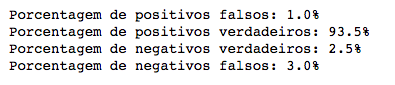

In [43]:
from IPython.display import Image
Image(filename='porcentagem.png')


** Possíveis otimizações : **

<p>Para implementar e aumentar a confiabilidade do classificador, seria viável colher mais tweets para testes, levando em conta também o contexto no qual foram compartilhados, tendo em vista o alto número de retweets, gifs e imagens. Como o classificador ainda não consegue ler e interpretar imagens, uma opção seria usar o url fonte da imagem ou gif, afim de tentar analisar o contexto no qual a imagem está inserida.</p>

<p>O MVP desenvolvido foca na classificação de tweets de forma a destacar aqueles que podem ser mais relevantes para uma dada empresa, no caso a Nike, tendo em vista que muitas das postagens não fazem qualquer crítica, sugestão ou comentário que mereça atenção por não afetar positivamente ou mesmo negativamente a marca. Dessa forma, uma possível iteração para otimização na classificação de tweets seria a categorização de mais níveis que expressem mais especificamente a intenção na publicação de um tweet. Em se tratando de uma especificação de positivos e negativos, é necessário ressaltar que algumas palavras contidas na mensagem podem determinar o tom da crítica e são facilmente identificadas na base de treinamento por conta do contexto, como por exemplo palavras de negação (não, nunca, never, not, can’t). Por outro lado, na validação do programa ao rodar a planilha de testes podem ocorrer alguns conflitos e gerar interpretações contrários por conta das mesmas palavras. Uma sugestão é, para qualquer palavra que estiver entre uma palavra de negação e o fim do tweet ou um sinal de pontuação, pode ser classificada como negativa. Por exemplo, uma frase do tipo: “That sneaker was not the best thing I’ve ever wore” pode ser classificada erroneamente como positiva por conter a palavra best, mas se ambas analisadas juntas, sendo “best” seguindo de not, ela passa a ser então classificada corretamente. Pode-se programar isso de forma que o classificador reconheça se uma palavra vem antes da outra ao comparar seus indices em uma lista</p>

<p>O classificador que estamos utilizando no desenvolvimento do MVP, o Naive Bayes, é um algoritmo de aprendizado de máquina supervisionado, ou seja, seu aprendizado é feito usando uma verdade básica, ou em outras palavras, temos conhecimento prévio de quais devem ser os valores de saída para nossas amostras. Em outros machine learnings, uma maneira de fazer com que não fosse preciso avaliar fazer manualmente cada tweet para poder fazer a programação , teria que fazer uma espécie de memória para que os tweets pudessem ser analisados automaticamente, sem precisar fazer manualmente. Por exemplo, como a memória de uma pessoa: ao ser alfabetizado, ao ser ensinado que de que a junção das letras "m" e "o"  formam "mo", ao ler depois em uma palavra, a criança lembrará como pronunciar tal.</p>